### **Import Libraries**

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supress warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs

# Scikit-learn untuk preprocessing dan modeling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Model boosting terbaru
from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from ngboost.scores import LogScore  
from snapml import BoostingMachineClassifier  

from lib.utils import gcForest

from pytorch_tabnet.tab_model import TabNetClassifier

# Hyperparameter tuning
import optuna
from skopt import BayesSearchCV 

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)


### **Load & Split Data**

In [2]:
df = pd.read_csv('data/cleaned_data.csv')

cols_to_keep = [
    "age", 
    "height", 
    "weight", 
    "systolic", 
    "diastolic", 
    "cholesterol", 
    "gluc", 
    "gender", 
    "smoke", 
    "alco", 
    "active", 
    "cardio"
]

df = df[cols_to_keep]

print('Sample Data')
display(df.head())

Sample Data


,age,height,weight,systolic,diastolic,cholesterol,gluc,gender,smoke,alco,active,cardio
0,50,168,62.0,110,80,0,0,1,0,0,1,0
1,55,156,85.0,140,90,2,0,0,0,0,1,1
2,51,165,64.0,130,70,2,0,0,0,0,0,1
3,48,169,82.0,150,100,0,0,1,0,0,1,1
4,60,151,67.0,120,80,1,1,0,0,0,0,0


In [3]:
X = df.drop('cardio', axis=1)  
y = df['cardio']   

In [4]:
label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

### **Scaling Data**

In [5]:
standard_features = ['age', 'height', 'weight','systolic', 'diastolic']
categorical_features = [ 'cholesterol', 'gluc','gender', 'smoke', 'alco', 'active']

assert all(feature in X.columns for feature in standard_features + categorical_features)

In [6]:
scaler_standard = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', scaler_standard, standard_features)
    ],
    remainder='passthrough'  
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

X_preprocessed = pd.DataFrame(X_preprocessed, columns=standard_features + categorical_features)
X_preprocessed

,age,height,weight,systolic,diastolic,cholesterol,gluc,gender,smoke,alco,active
0,-0.430669,0.443359,-0.871462,-1.156541,-0.232418,0.0,0.0,1.0,0.0,0.0,1.0
1,0.310831,-1.092488,0.761405,0.929243,1.064264,2.0,0.0,0.0,0.0,0.0,1.0
2,-0.282369,0.059397,-0.729474,0.233982,-1.529099,2.0,0.0,0.0,0.0,0.0,0.0
3,-0.727269,0.571346,0.548422,1.624505,2.360945,0.0,0.0,1.0,0.0,0.0,1.0
4,1.052331,-1.732424,-0.516491,-0.461280,-0.232418,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
64375,0.607431,0.059397,0.406434,1.624505,-0.232418,0.0,0.0,0.0,0.0,0.0,1.0
64376,-0.134069,0.443359,0.122457,-0.461280,-0.232418,0.0,0.0,1.0,1.0,0.0,1.0
64377,1.200631,-0.836513,3.672168,0.929243,1.064264,1.0,1.0,0.0,0.0,0.0,1.0
64378,1.200631,-0.196577,-0.161520,0.581613,-0.232418,0.0,1.0,0.0,0.0,0.0,0.0


### **Train, Val, Test**

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42, stratify=y)  # Train 70%
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)  # Val 20%, Test 10%

In [8]:
# NumPy array format
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

### **Base Model**

In [9]:
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    """
    Generic evaluation function that adapts its training and prediction process
    based on the model type.
    
    If the model has a 'cascade_forest' method (e.g., gcForest), it will use that
    for training and prediction; otherwise, it assumes the model follows the standard
    interface (fit, predict, predict_proba).
    """
    # Determine the branch based on model type
    if hasattr(model, 'cascade_forest'):
        print("Using cascade_forest branch for training and prediction...")
        # Train the model with cascade_forest (when y is provided, training occurs)
        model.cascade_forest(x_train, y_train)
        # Define lambda functions for prediction and probability prediction
        predict_func = lambda x: np.argmax(np.mean(model.cascade_forest(x), axis=0), axis=1)
        predict_proba_func = lambda x: np.mean(model.cascade_forest(x), axis=0)
    else:
        print("Using standard branch (fit/predict/predict_proba)...")
        model.fit(x_train, y_train)
        predict_func = lambda x: model.predict(x)
        predict_proba_func = lambda x: model.predict_proba(x)
    
    # Predictions on test data
    y_pred_test = predict_func(x_test)
    y_proba_test = predict_proba_func(x_test)
    
    # For binary classification, use the probability for the positive class (index 1)
    if y_proba_test.shape[1] > 1:
        y_probs_test = y_proba_test[:, 1]
    else:
        y_probs_test = y_proba_test[:, 0]
    
    # Predictions on training data (for overfitting check)
    y_pred_train = predict_func(x_train)
    y_proba_train = predict_proba_func(x_train)
    if y_proba_train.shape[1] > 1:
        y_probs_train = y_proba_train[:, 1]
    else:
        y_probs_train = y_proba_train[:, 0]
    
    # Calculate evaluation metrics
    test_accuracy = accuracy_score(y_test, y_pred_test) * 100
    test_auc = roc_auc_score(y_test, y_probs_test)
    test_report = classification_report(y_test, y_pred_test)
    
    train_accuracy = accuracy_score(y_train, y_pred_train) * 100
    train_auc = roc_auc_score(y_train, y_probs_train)
    
    # Print evaluation results
    print(f"\nClassification Report for {model_name}:\n{test_report}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.2f}%")
    print(f"{model_name} Test AUC: {test_auc:.4f}")
    print(f"\n{model_name} Training Accuracy: {train_accuracy:.2f}%")
    print(f"{model_name} Training AUC: {train_auc:.4f}")
    
    print("\nOverfitting Check:")
    if train_accuracy > test_accuracy + 5 or train_auc > test_auc + 0.05:
        print("The model might be overfitting.")
    else:
        print("No significant signs of overfitting.")
    
    # Plot Confusion Matrix and ROC Curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    cm = confusion_matrix(y_test, y_pred_test)
    # If a global variable 'label_mapping' exists, use it for display labels
    display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=axes[0], cmap='viridis', colorbar=False)
    axes[0].set_title(f"{model_name} - Confusion Matrix")
    
    fpr, tpr, _ = roc_curve(y_test, y_probs_test)
    axes[1].plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.4f})", linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
    axes[1].set_title(f"{model_name} - ROC Curve")
    axes[1].legend(loc="lower right")
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

##### `Logistic Regression`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      3222
           1       0.75      0.66      0.70      3216

    accuracy                           0.72      6438
   macro avg       0.73      0.72      0.72      6438
weighted avg       0.73      0.72      0.72      6438

Logistic Regression Test Accuracy: 72.27%
Logistic Regression Test AUC: 0.7913

Logistic Regression Training Accuracy: 72.30%
Logistic Regression Training AUC: 0.7859

Overfitting Check:
No significant signs of overfitting.


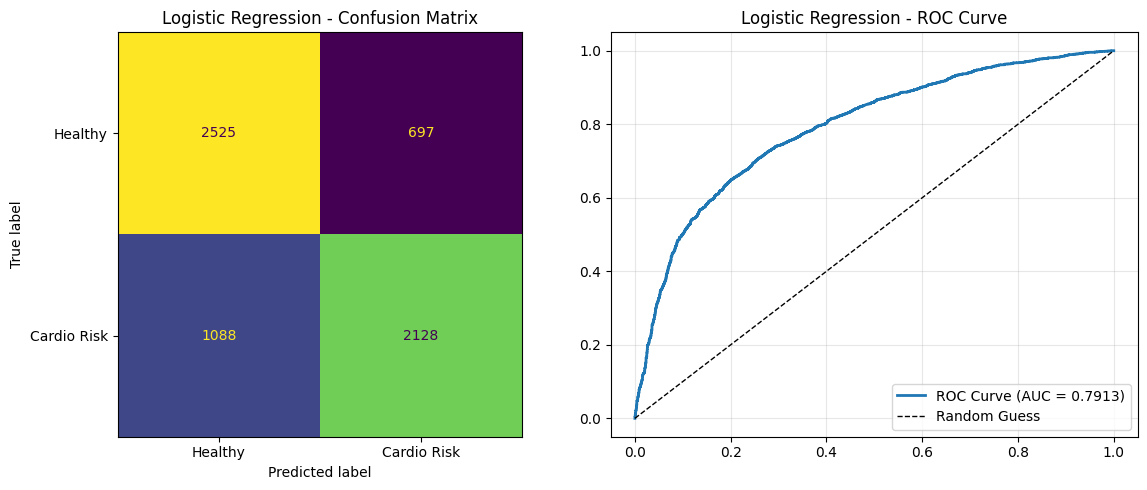

In [10]:
logreg_model = LogisticRegression()

evaluate_model(logreg_model, x_train_np, y_train_np, x_test_np, y_test_np, "Logistic Regression")

##### `Random Forest`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      3222
           1       0.70      0.69      0.70      3216

    accuracy                           0.70      6438
   macro avg       0.70      0.70      0.70      6438
weighted avg       0.70      0.70      0.70      6438

Random Forest Test Accuracy: 69.93%
Random Forest Test AUC: 0.7594

Random Forest Training Accuracy: 97.97%
Random Forest Training AUC: 0.9982

Overfitting Check:
The model might be overfitting.


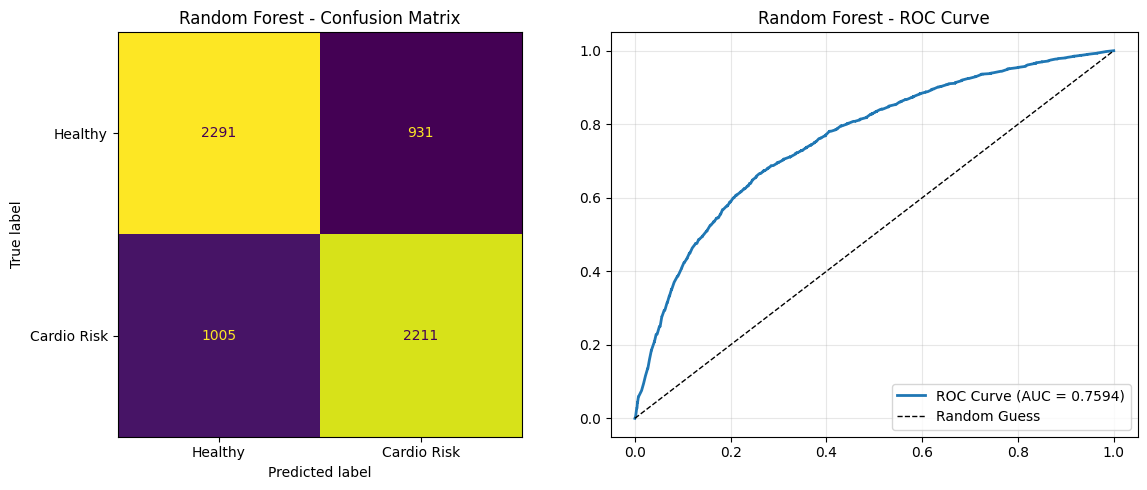

In [11]:
rf_model = RandomForestClassifier()

evaluate_model(rf_model, x_train_np, y_train_np, x_test_np, y_test_np, "Random Forest")

##### `Decision Tree`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      3222
           1       0.63      0.61      0.62      3216

    accuracy                           0.63      6438
   macro avg       0.63      0.63      0.63      6438
weighted avg       0.63      0.63      0.63      6438

Decision Tree Test Accuracy: 62.94%
Decision Tree Test AUC: 0.6305

Decision Tree Training Accuracy: 97.97%
Decision Tree Training AUC: 0.9991

Overfitting Check:
The model might be overfitting.


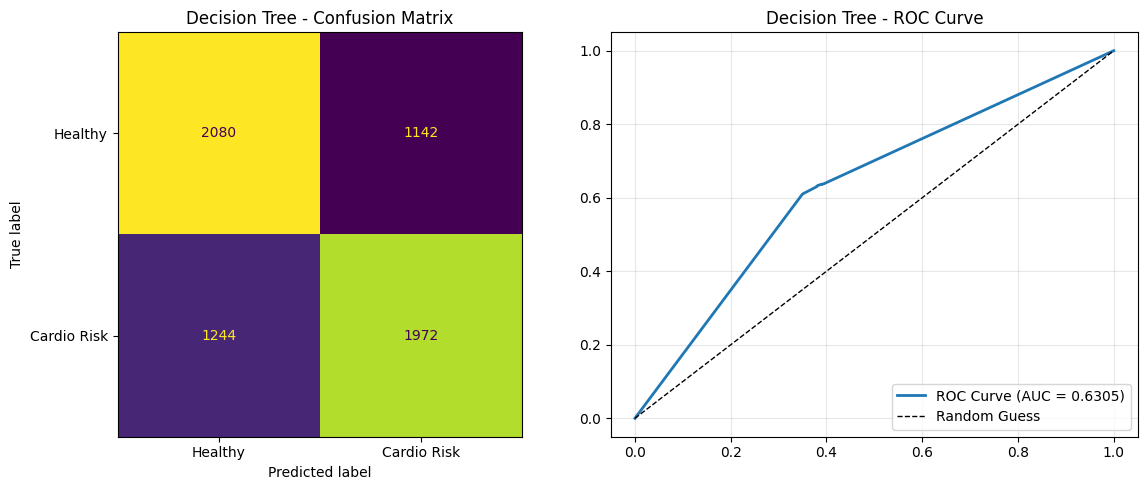

In [12]:
dt_model = DecisionTreeClassifier()

evaluate_model(dt_model, x_train_np, y_train_np, x_test_np, y_test_np, "Decision Tree")

##### `SVM`

Using standard branch (fit/predict/predict_proba)...

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3222
           1       0.76      0.67      0.71      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

SVM Test Accuracy: 73.10%
SVM Test AUC: 0.7852

SVM Training Accuracy: 73.30%
SVM Training AUC: 0.7929

Overfitting Check:
No significant signs of overfitting.


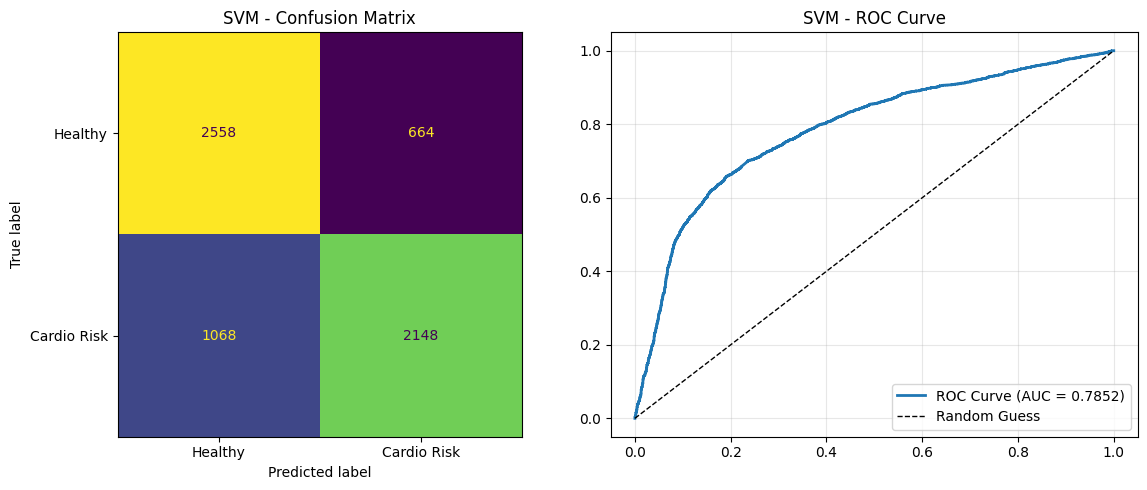

In [13]:
svm_model = SVC(probability=True)

evaluate_model(svm_model, x_train_np, y_train_np, x_test_np, y_test_np, "SVM")

##### `Naive Bayes`

Using standard branch (fit/predict/predict_proba)...



Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      3222
           1       0.77      0.62      0.69      3216

    accuracy                           0.72      6438
   macro avg       0.72      0.72      0.71      6438
weighted avg       0.72      0.72      0.71      6438

Naive Bayes Test Accuracy: 71.59%
Naive Bayes Test AUC: 0.7781

Naive Bayes Training Accuracy: 71.00%
Naive Bayes Training AUC: 0.7738

Overfitting Check:
No significant signs of overfitting.


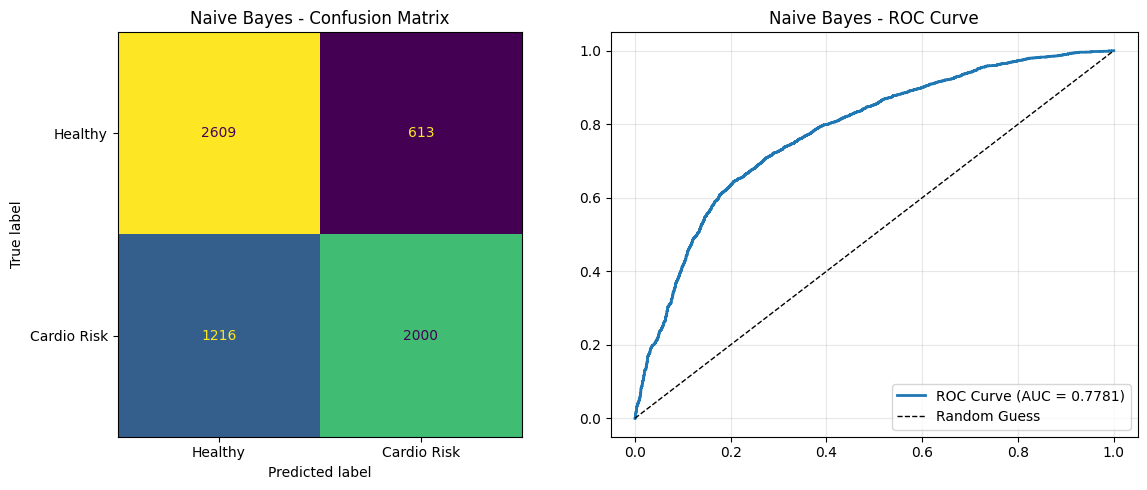

In [14]:
nb_model = GaussianNB()

evaluate_model(nb_model, x_train_np, y_train_np, x_test_np, y_test_np, "Naive Bayes")

##### `KNN`

Using standard branch (fit/predict/predict_proba)...

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      3222
           1       0.70      0.69      0.69      3216

    accuracy                           0.70      6438
   macro avg       0.70      0.70      0.70      6438
weighted avg       0.70      0.70      0.70      6438

KNN Test Accuracy: 69.66%
KNN Test AUC: 0.7446

KNN Training Accuracy: 78.02%
KNN Training AUC: 0.8653

Overfitting Check:
The model might be overfitting.


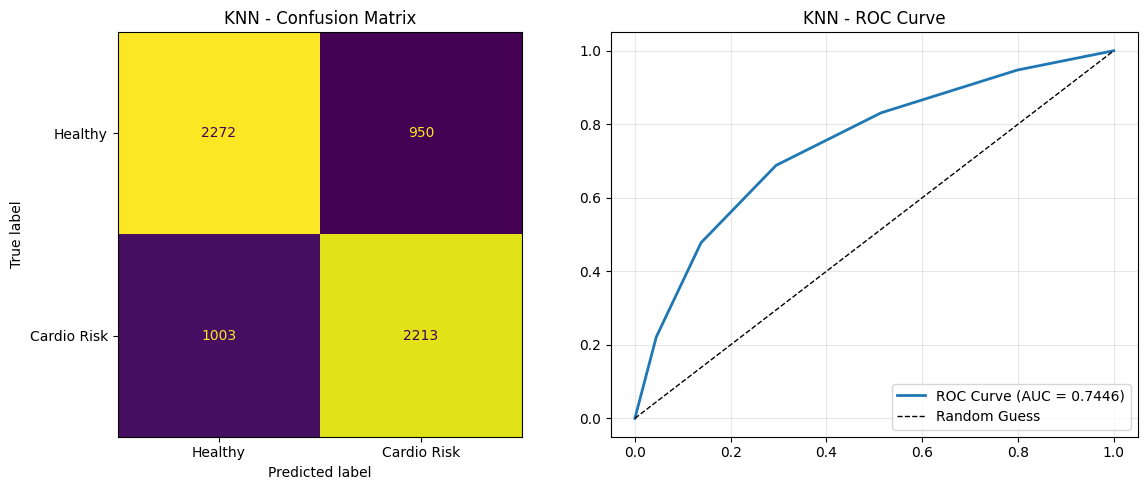

In [15]:
knn_model = KNeighborsClassifier()

evaluate_model(knn_model, x_train_np, y_train_np, x_test_np, y_test_np, "KNN")

##### `XGBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      3222
           1       0.74      0.69      0.71      3216

    accuracy                           0.72      6438
   macro avg       0.73      0.72      0.72      6438
weighted avg       0.73      0.72      0.72      6438

XGBoost Test Accuracy: 72.46%
XGBoost Test AUC: 0.7921

XGBoost Training Accuracy: 76.09%
XGBoost Training AUC: 0.8390

Overfitting Check:
No significant signs of overfitting.


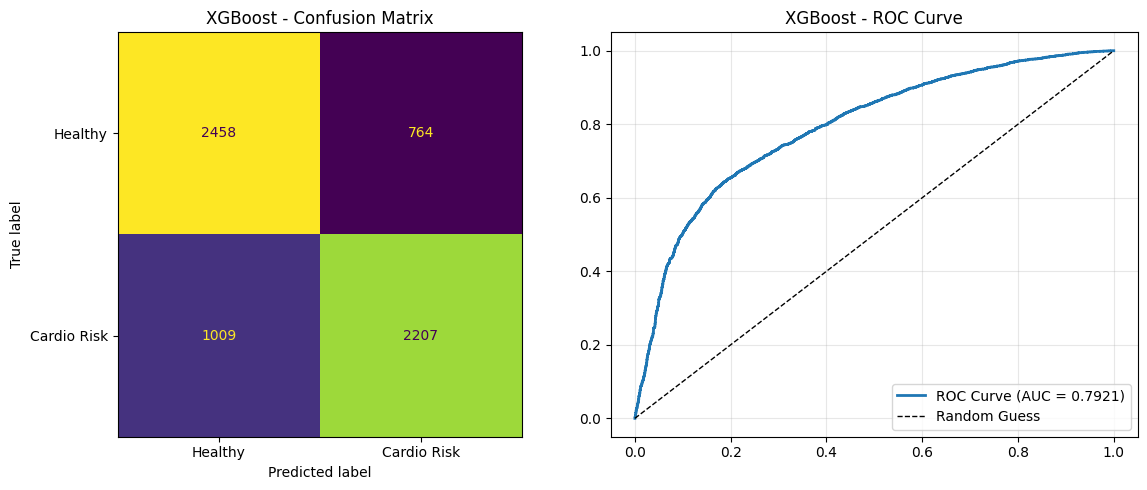

In [16]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

evaluate_model(xgb_model, x_train_np, y_train_np, x_test_np, y_test_np, "XGBoost")

##### `Light GBM`

Using standard branch (fit/predict/predict_proba)...

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3222
           1       0.75      0.69      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

LightGBM Test Accuracy: 72.96%
LightGBM Test AUC: 0.7991

LightGBM Training Accuracy: 74.48%
LightGBM Training AUC: 0.8194

Overfitting Check:
No significant signs of overfitting.


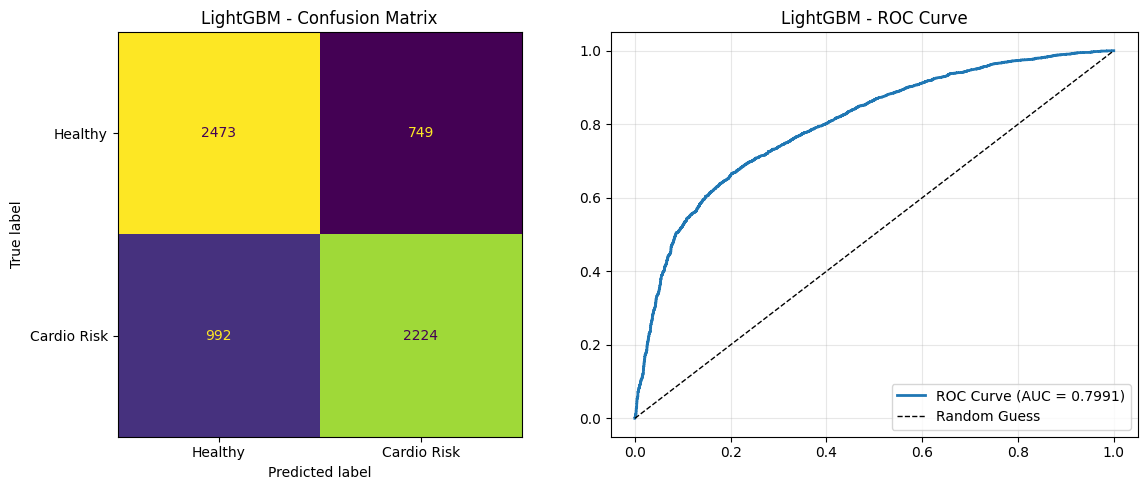

In [17]:
lgbm_model = LGBMClassifier(verbose=-1)

evaluate_model(lgbm_model, x_train_np, y_train_np, x_test_np, y_test_np, "LightGBM")

##### `Cat Boost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      3222
           1       0.74      0.69      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

CatBoost Test Accuracy: 72.68%
CatBoost Test AUC: 0.7975

CatBoost Training Accuracy: 75.32%
CatBoost Training AUC: 0.8292

Overfitting Check:
No significant signs of overfitting.


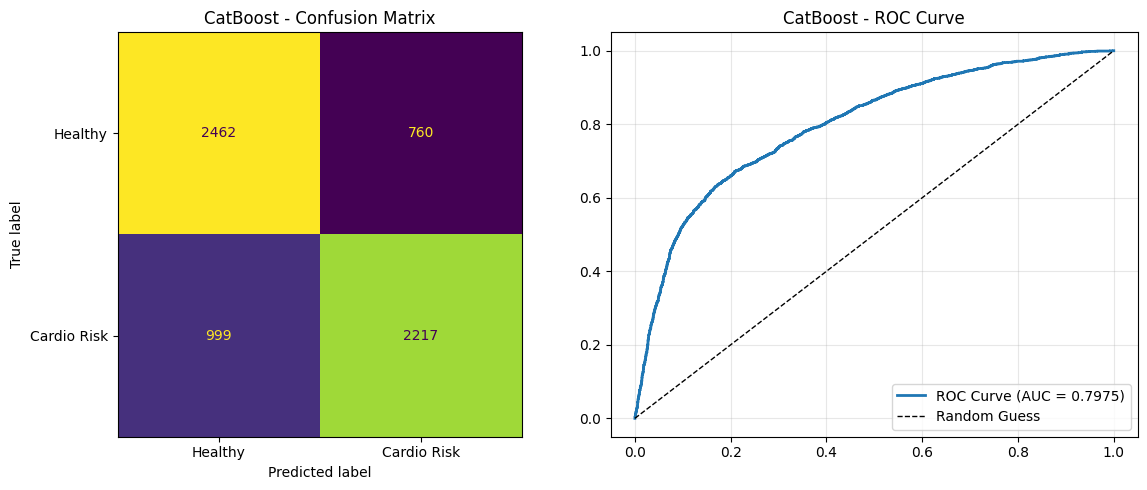

In [18]:
cat_model = CatBoostClassifier(verbose=False)


evaluate_model(cat_model, x_train_np, y_train_np, x_test_np, y_test_np, "CatBoost")

#### `SnapBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for SnapBoost:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3222
           1       0.75      0.69      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

SnapBoost Test Accuracy: 72.86%
SnapBoost Test AUC: 0.8003

SnapBoost Training Accuracy: 73.35%
SnapBoost Training AUC: 0.8042

Overfitting Check:
No significant signs of overfitting.


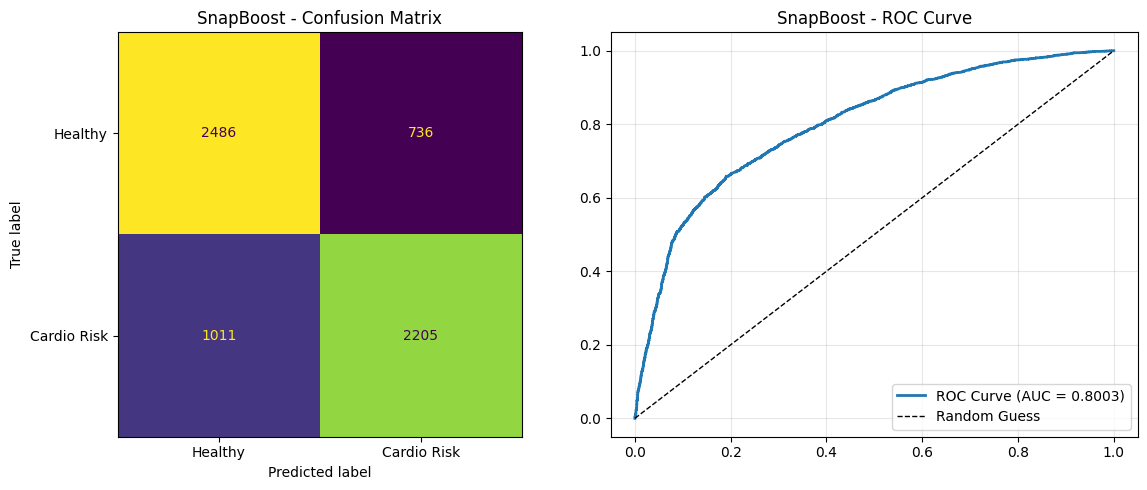

In [19]:
snb_model = BoostingMachineClassifier()

evaluate_model(snb_model, x_train_np, y_train_np, x_test_np, y_test_np, "SnapBoost")

##### `Explainable Boosting Machine (EBM)`

Using standard branch (fit/predict/predict_proba)...

Classification Report for EBM:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3222
           1       0.75      0.69      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

EBM Test Accuracy: 72.80%
EBM Test AUC: 0.7999

EBM Training Accuracy: 73.07%
EBM Training AUC: 0.7983

Overfitting Check:
No significant signs of overfitting.


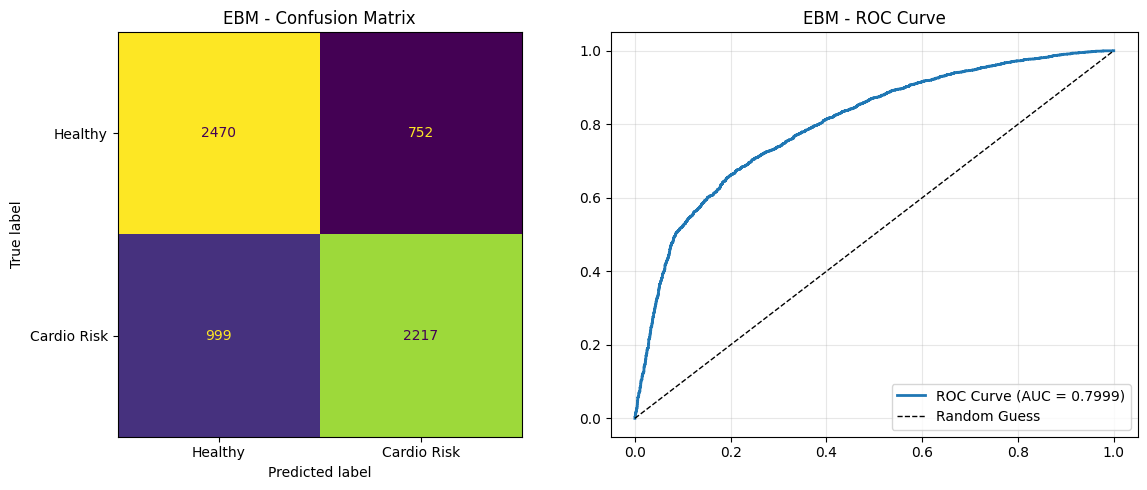

In [20]:
ebm_model = ExplainableBoostingClassifier()

evaluate_model(ebm_model, x_train_np, y_train_np, x_test_np, y_test_np, "EBM")

##### `NGBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for NGBoost:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      3222
           1       0.74      0.69      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

NGBoost Test Accuracy: 72.65%
NGBoost Test AUC: 0.7986

NGBoost Training Accuracy: 72.97%
NGBoost Training AUC: 0.7980

Overfitting Check:
No significant signs of overfitting.


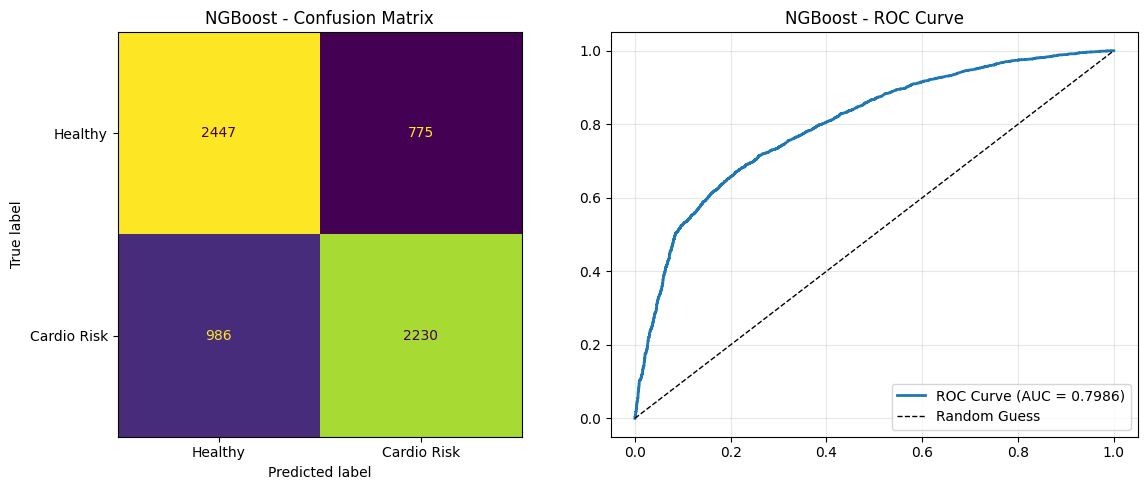

In [21]:
ngb_model = NGBClassifier(Dist=Bernoulli, verbose=False)

evaluate_model(ngb_model, x_train_np, y_train_np, x_test_np, y_test_np, "NGBoost")

##### `AdaBoost`

Using standard branch (fit/predict/predict_proba)...

Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3222
           1       0.76      0.65      0.70      3216

    accuracy                           0.72      6438
   macro avg       0.73      0.72      0.72      6438
weighted avg       0.73      0.72      0.72      6438

AdaBoost Test Accuracy: 72.38%
AdaBoost Test AUC: 0.7935

AdaBoost Training Accuracy: 72.44%
AdaBoost Training AUC: 0.7902

Overfitting Check:
No significant signs of overfitting.


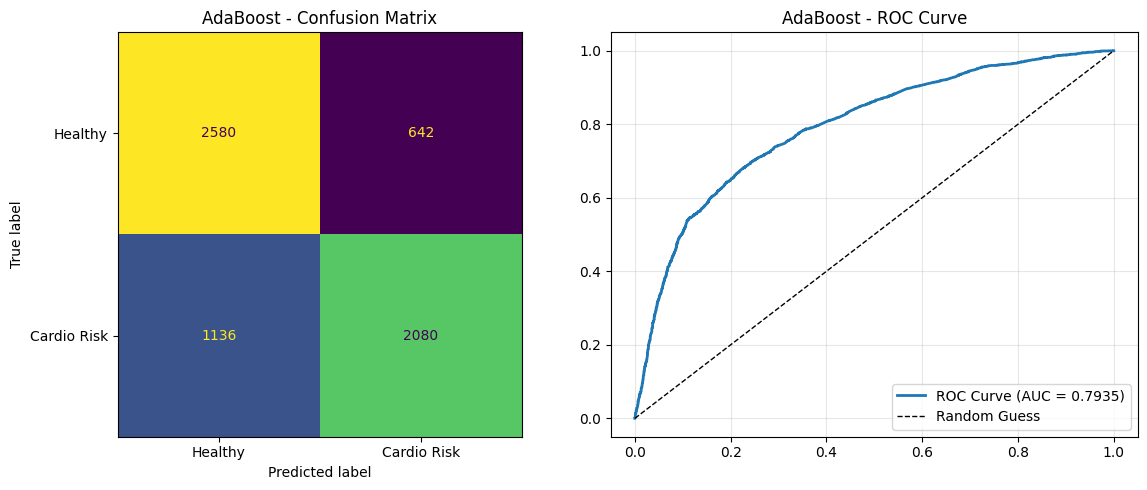

In [22]:
adb_model = AdaBoostClassifier(random_state=42)

evaluate_model(adb_model, x_train_np, y_train_np, x_test_np, y_test_np, "AdaBoost")

##### `GradientBoosting`

Using standard branch (fit/predict/predict_proba)...



Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3222
           1       0.75      0.70      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

Gradient Boosting Test Accuracy: 72.96%
Gradient Boosting Test AUC: 0.7994

Gradient Boosting Training Accuracy: 73.22%
Gradient Boosting Training AUC: 0.8001

Overfitting Check:
No significant signs of overfitting.


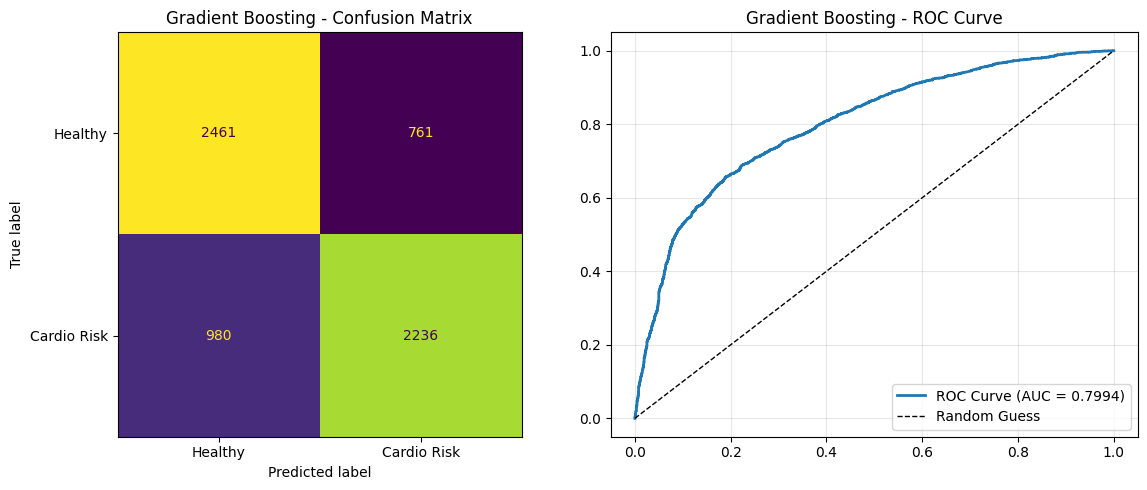

In [23]:
grb_model =  GradientBoostingClassifier(random_state=42)

evaluate_model(grb_model, x_train_np, y_train_np, x_test_np, y_test_np, "Gradient Boosting")

##### `Hist GradientBoosting`

Using standard branch (fit/predict/predict_proba)...

Classification Report for Hist Gradient Boosting:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      3222
           1       0.75      0.69      0.72      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

Hist Gradient Boosting Test Accuracy: 72.72%
Hist Gradient Boosting Test AUC: 0.7999

Hist Gradient Boosting Training Accuracy: 73.93%
Hist Gradient Boosting Training AUC: 0.8107

Overfitting Check:
No significant signs of overfitting.


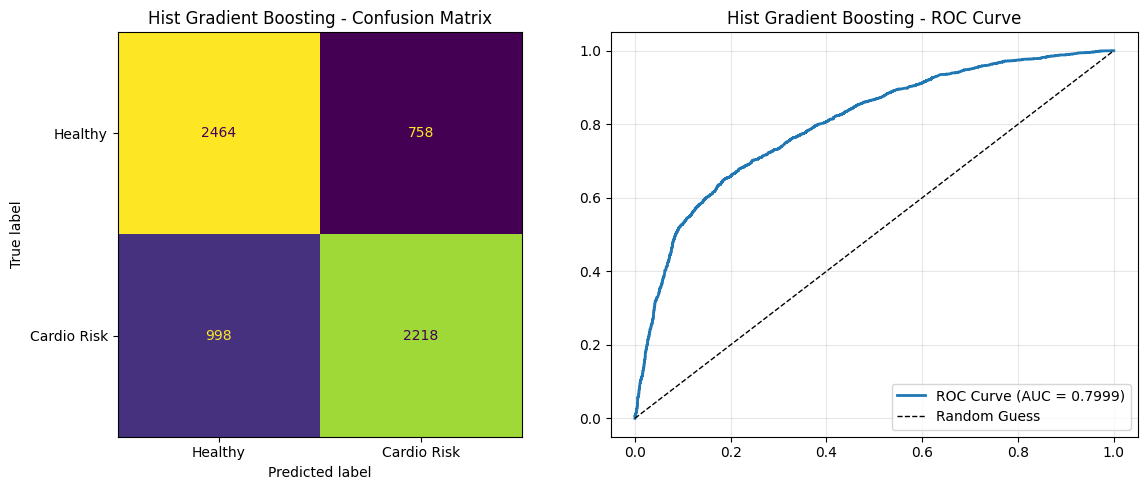

In [24]:
hgrb_model =  HistGradientBoostingClassifier(random_state=42)

evaluate_model(hgrb_model, x_train_np, y_train_np, x_test_np, y_test_np, "Hist Gradient Boosting")

#### `Cascaded Random Forest`

Using cascade_forest branch for training and prediction...
Adding/Training Layer, n_layer=1
Layer validation accuracy = 0.7265364987796761
Adding/Training Layer, n_layer=2
Layer validation accuracy = 0.7290880852007987
Adding/Training Layer, n_layer=3
Layer validation accuracy = 0.7291990237408476
Adding/Training Layer, n_layer=4
Layer validation accuracy = 0.7305302862214333
Adding/Training Layer, n_layer=5
Layer validation accuracy = 0.729531839360994

Classification Report for Cascaded Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.79      0.74      3222
           1       0.76      0.67      0.71      3216

    accuracy                           0.73      6438
   macro avg       0.73      0.73      0.73      6438
weighted avg       0.73      0.73      0.73      6438

Cascaded Random Forest Test Accuracy: 72.99%
Cascaded Random Forest Test AUC: 0.7967

Cascaded Random Forest Training Accuracy: 73.15%
Cascaded Random Forest Traini

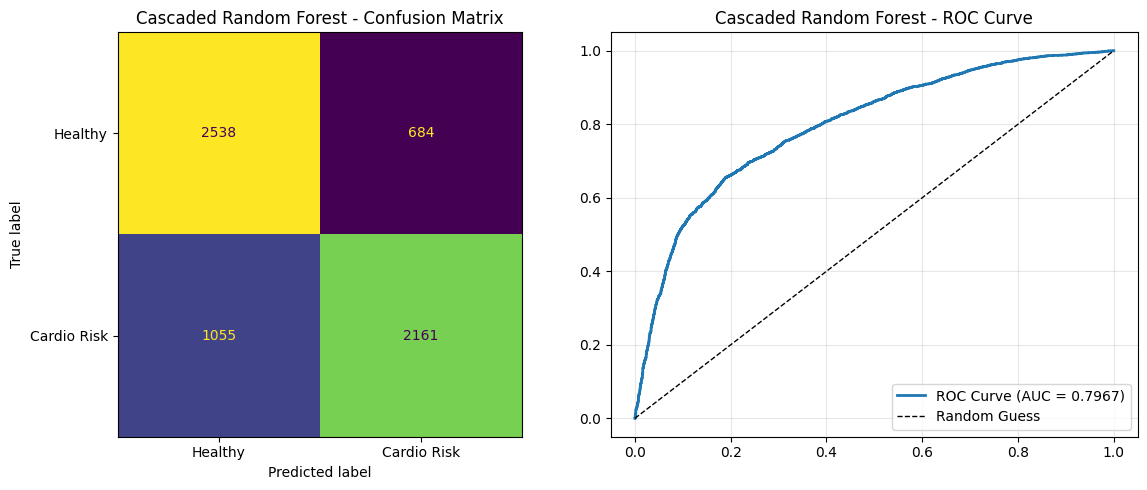

In [25]:
gcf_model = gcForest(n_cascadeRF=2,n_cascadeRFtree=500) #Default values tolerance =0.0 ,n_cascadeRFtree=101

evaluate_model(gcf_model, x_train_np, y_train_np, x_test_np, y_test_np, "Cascaded Random Forest")

#### `TabNet`

Using standard branch (fit/predict/predict_proba)...
epoch 0  | loss: 0.59892 |  0:00:01s
epoch 1  | loss: 0.56216 |  0:00:02s
epoch 2  | loss: 0.55811 |  0:00:03s
epoch 3  | loss: 0.5574  |  0:00:04s
epoch 4  | loss: 0.5561  |  0:00:05s
epoch 5  | loss: 0.55519 |  0:00:06s
epoch 6  | loss: 0.55412 |  0:00:07s
epoch 7  | loss: 0.55358 |  0:00:08s
epoch 8  | loss: 0.55448 |  0:00:09s
epoch 9  | loss: 0.55438 |  0:00:10s
epoch 10 | loss: 0.55364 |  0:00:11s
epoch 11 | loss: 0.55254 |  0:00:13s
epoch 12 | loss: 0.55189 |  0:00:14s
epoch 13 | loss: 0.55188 |  0:00:15s
epoch 14 | loss: 0.55217 |  0:00:16s
epoch 15 | loss: 0.55179 |  0:00:17s
epoch 16 | loss: 0.55307 |  0:00:18s
epoch 17 | loss: 0.55135 |  0:00:19s
epoch 18 | loss: 0.5521  |  0:00:20s
epoch 19 | loss: 0.55224 |  0:00:21s
epoch 20 | loss: 0.55083 |  0:00:22s
epoch 21 | loss: 0.55202 |  0:00:23s
epoch 22 | loss: 0.55123 |  0:00:24s
epoch 23 | loss: 0.5509  |  0:00:25s
epoch 24 | loss: 0.55096 |  0:00:26s
epoch 25 | loss: 0.551

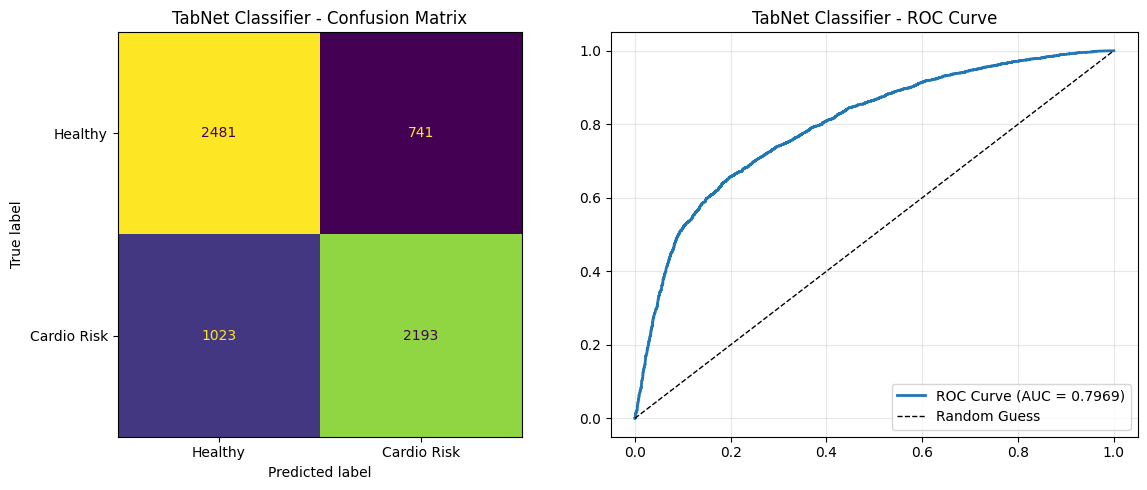

In [26]:
tabnet_model = TabNetClassifier()

evaluate_model(tabnet_model, x_train_np, y_train_np, x_test_np, y_test_np, "TabNet Classifier")

#### `DANet`